In [74]:
import cv2
import matplotlib.pyplot as plt
import numpy as np

In [75]:
image_path = "D:/Holland_Year_2\Block_B/2024-25b-fai2-adsai-PetarPaskalev232725/datalab_tasks/task3/task_3_image_1.png"

In [76]:
image = cv2.imread(image_path)

In [77]:
type(image)

numpy.ndarray

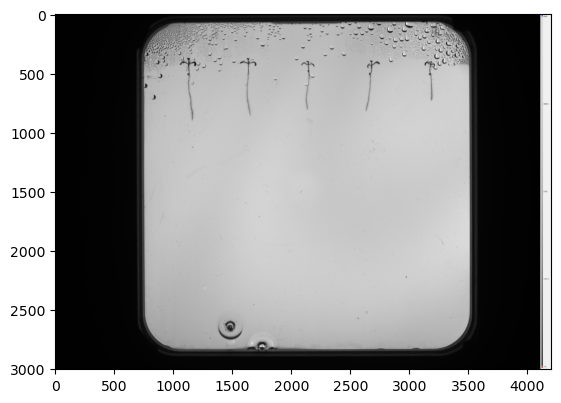

In [78]:
plt.imshow(image)

In [79]:
# Edge Detection Function
def detect_edges(image):
    """Detect edges to find the approximate square Petri dish."""
    # Apply Gaussian blur to smooth the image
    blurred_image = cv2.GaussianBlur(image, (51, 51), 0)

    # Compute horizontal and vertical gradients
    sobel_x = cv2.Sobel(blurred_image, cv2.CV_64F, 1, 0, ksize=5)
    sobel_y = cv2.Sobel(blurred_image, cv2.CV_64F, 0, 1, ksize=5)

    # Calculate the gradient magnitude
    gradient_magnitude = cv2.magnitude(sobel_x, sobel_y)

    # Threshold to identify strong edges
    _, edges = cv2.threshold(gradient_magnitude, 50, 255, cv2.THRESH_BINARY)

    # Convert to single-channel grayscale
    edges = edges.astype(np.uint8)
    if len(edges.shape) == 3:  # Check if multi-channel
        edges = cv2.cvtColor(edges, cv2.COLOR_BGR2GRAY)

    # Find contours to identify the Petri dish
    contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Assume the largest square-like contour is the Petri dish
    max_contour = max(contours, key=cv2.contourArea)
    x, y, w, h = cv2.boundingRect(max_contour)

    return x, x + w, y, y + h


In [80]:
# Crop Image Function
def crop_image(image, edges):
    """Crop the image based on detected edges and return the cropped region."""
    left, right, top, bottom = edges
    return image[top:bottom, left:right]



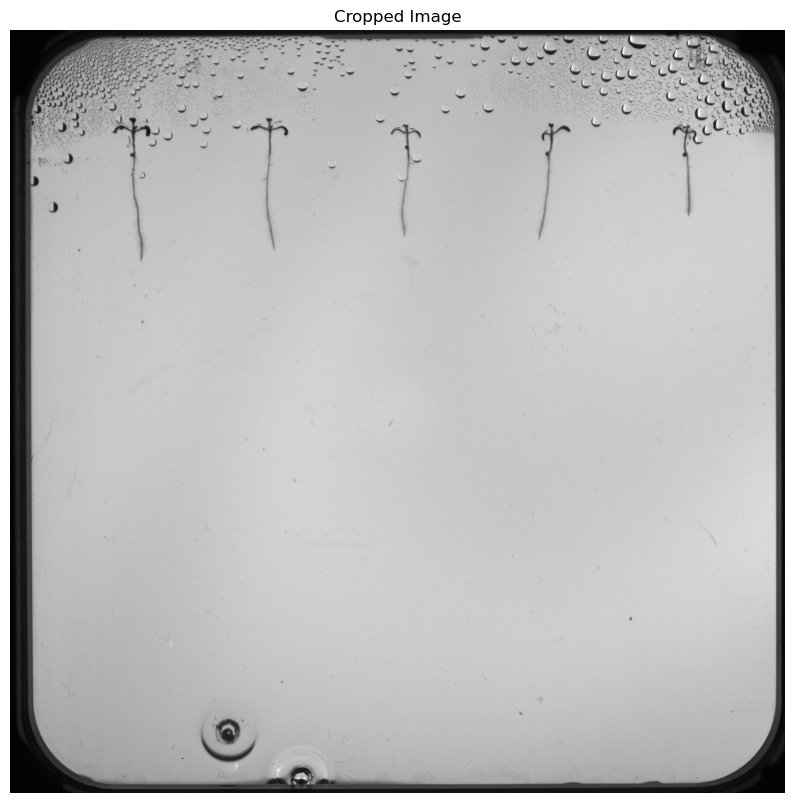

In [81]:
# Detect edges and crop the image
edges = detect_edges(image)
cropped_image = crop_image(image, edges)

# Display the cropped image
plt.figure(figsize=(10, 10))
plt.imshow(cropped_image, cmap='gray')
plt.title("Cropped Image")
plt.axis('off')
plt.show()


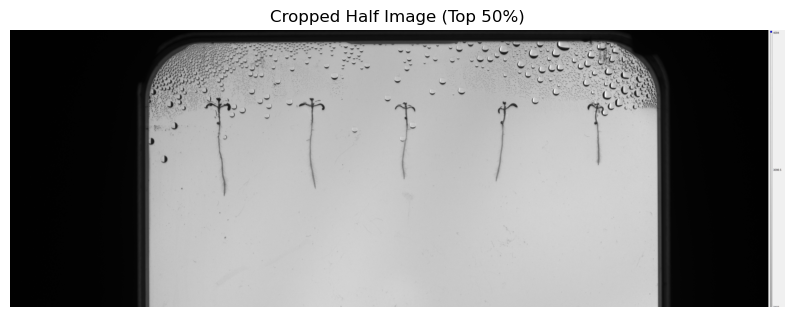

In [82]:
# Crop the bottom half of the image
cropped_half_image = image[:image.shape[0] // 2, :]

# Display the cropped half image
plt.figure(figsize=(10, 10))
plt.imshow(cropped_half_image, cmap='gray')
plt.title("Cropped Half Image (Top 50%)")
plt.axis('off')
plt.show()

# Replace the original image with the cropped half image for further processing
cropped_image = cropped_half_image


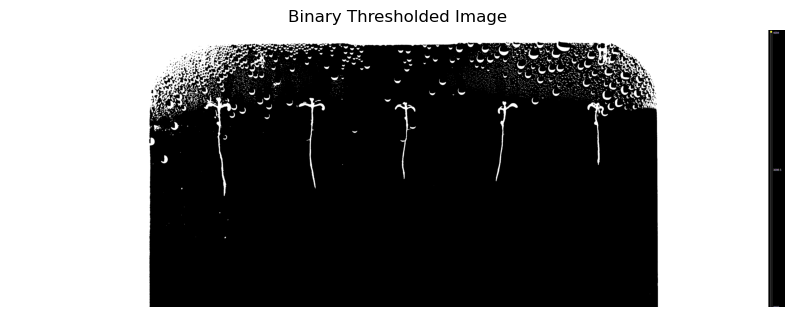

In [83]:
# Apply binary threshold
_, binary_image = cv2.threshold(cropped_image, 160, 255, cv2.THRESH_BINARY_INV)

# Display the binary thresholded image
plt.figure(figsize=(10, 10))
plt.imshow(binary_image, cmap='gray')
plt.title("Binary Thresholded Image")
plt.axis('off')
plt.show()


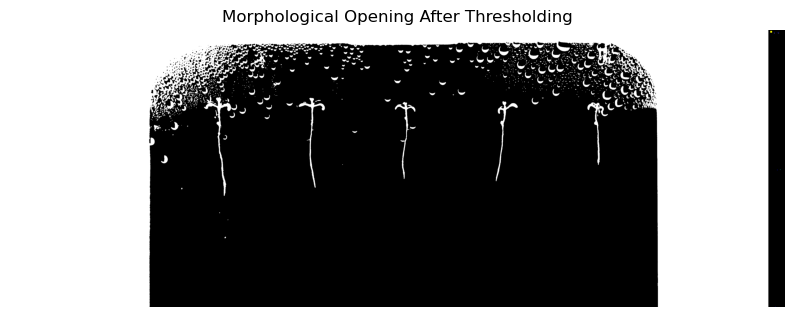

In [84]:
# Apply morphological opening to clean noise and connect components
kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3, 3))
opened_image = cv2.morphologyEx(binary_image, cv2.MORPH_OPEN, kernel)

# Display the result after morphological opening
plt.figure(figsize=(10, 10))
plt.imshow(opened_image, cmap='gray')
plt.title("Morphological Opening After Thresholding")
plt.axis('off')
plt.show()


In [85]:
# Ensure that the image is single-channel binary
if len(opened_image.shape) > 2:
    opened_image = cv2.cvtColor(opened_image, cv2.COLOR_BGR2GRAY)

_, opened_image = cv2.threshold(opened_image, 127, 255, cv2.THRESH_BINARY)

# Perform connected components analysis
numLabels, labels, stats, centroids = cv2.connectedComponentsWithStats(opened_image, connectivity=8)

# Sort components by area in descending order (excluding background, label 0)
sorted_stats = sorted(stats[1:], key=lambda stat: stat[cv2.CC_STAT_AREA], reverse=True)

# Display the total number of connected components (excluding background)
print(f"Total connected components (excluding background): {len(sorted_stats)}")

# Display stats for the top components
print("Stats for the top components (x, y, width, height, area):")
for i, stat in enumerate(sorted_stats[:10], start=1):  # Show top 10 components
    print(f"Component {i}: x={stat[cv2.CC_STAT_LEFT]}, y={stat[cv2.CC_STAT_TOP]}, "
          f"w={stat[cv2.CC_STAT_WIDTH]}, h={stat[cv2.CC_STAT_HEIGHT]}, area={stat[cv2.CC_STAT_AREA]}")


Total connected components (excluding background): 1090
Stats for the top components (x, y, width, height, area):
Component 1: x=0, y=0, w=4112, h=1503, area=2389513
Component 2: x=1052, y=356, w=179, h=547, area=9113
Component 3: x=1565, y=372, w=143, h=487, area=6024
Component 4: x=2634, y=391, w=119, h=432, area=5268
Component 5: x=3130, y=397, w=112, h=338, area=5172
Component 6: x=2087, y=395, w=111, h=416, area=4757
Component 7: x=1304, y=115, w=82, h=97, area=2075
Component 8: x=967, y=230, w=70, h=91, area=1714
Component 9: x=3343, y=150, w=52, h=109, area=1568
Component 10: x=3297, y=149, w=59, h=88, area=1460


In [86]:
# Ensure the image is grayscale before converting to BGR
if len(cropped_image.shape) == 2:  # Single channel (grayscale)
    output_image = cv2.cvtColor(cropped_image, cv2.COLOR_GRAY2BGR)
else:
    output_image = cropped_image.copy()  # Already in BGR


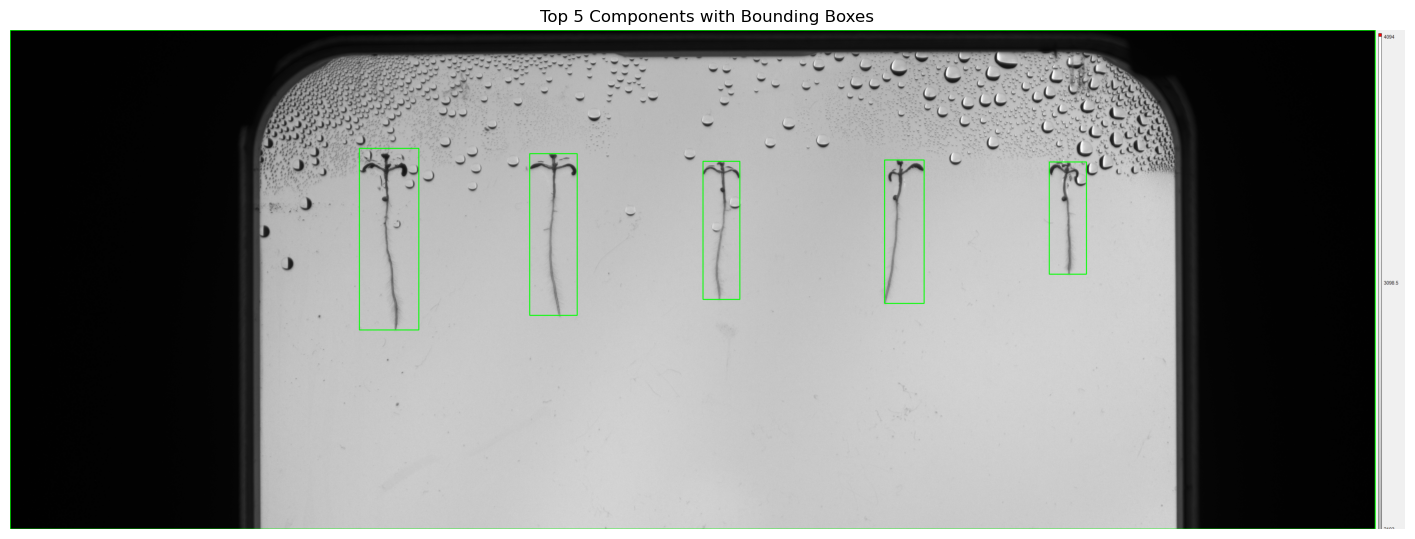

In [87]:
# Exclude the largest component (likely the background) and take the next 5 largest components
top_5_stats = sorted_stats[:6]  # Exclude the largest and take the next 5

# Ensure the image is in BGR format for drawing
if len(cropped_image.shape) == 2:  # Single channel (grayscale)
    output_image = cv2.cvtColor(cropped_image, cv2.COLOR_GRAY2BGR)
else:
    output_image = cropped_image.copy()  # Already in BGR

# Draw bounding boxes around the top 5 components
for stat in top_5_stats:
    x = stat[cv2.CC_STAT_LEFT]
    y = stat[cv2.CC_STAT_TOP]
    w = stat[cv2.CC_STAT_WIDTH]
    h = stat[cv2.CC_STAT_HEIGHT]
    cv2.rectangle(output_image, (x, y), (x + w, y + h), (0, 255, 0), 2)  # Green bounding box

# Display the final image with bounding boxes
plt.figure(figsize=(18, 12))
plt.imshow(cv2.cvtColor(output_image, cv2.COLOR_BGR2RGB))  # Convert BGR to RGB for matplotlib
plt.title("Top 5 Components with Bounding Boxes")
plt.axis('off')
plt.show()


C:\Users\35988\AppData\Local\Temp\ipykernel_40688\1526929097.py:25: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  viridis_cmap = cm.get_cmap('viridis', len(top_5_stats) + 1)


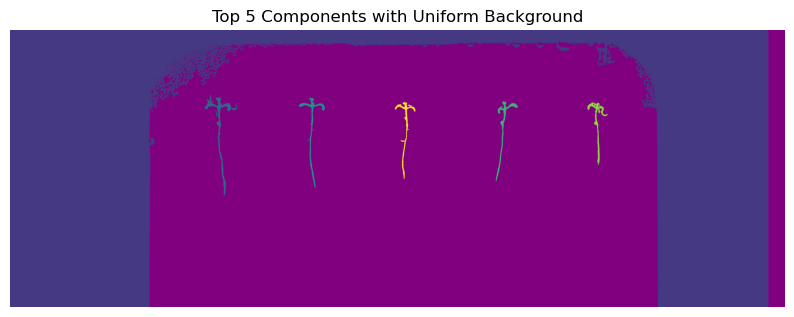

In [92]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm

# Step 1: Create a mask for the top 5 components (excluding the background)
component_mask = np.zeros_like(labels, dtype=np.uint8)

# Iterate over the top 5 stats
for i, stat in enumerate(top_5_stats):  # No need to skip the largest here
    label_idx = np.where(
        (stats[:, cv2.CC_STAT_LEFT] == stat[cv2.CC_STAT_LEFT]) &
        (stats[:, cv2.CC_STAT_TOP] == stat[cv2.CC_STAT_TOP]) &
        (stats[:, cv2.CC_STAT_WIDTH] == stat[cv2.CC_STAT_WIDTH]) &
        (stats[:, cv2.CC_STAT_HEIGHT] == stat[cv2.CC_STAT_HEIGHT]) &
        (stats[:, cv2.CC_STAT_AREA] == stat[cv2.CC_STAT_AREA])
    )[0][0]
    # Assign a unique value for the component in the mask
    component_mask[labels == label_idx] = i + 1

# Step 2: Create a solid purple background
output_image = np.zeros((component_mask.shape[0], component_mask.shape[1], 3), dtype=np.uint8)
output_image[:, :] = [128, 0, 128]  # Purple background for the entire image

# Step 3: Apply Viridis colormap to the top 5 components
viridis_cmap = cm.get_cmap('viridis', len(top_5_stats) + 1)
for i in range(1, len(top_5_stats) + 1):
    color = (np.array(viridis_cmap(i / len(top_5_stats))[:3]) * 255).astype(np.uint8)
    output_image[component_mask == i] = color

# Step 4: Display the result
plt.figure(figsize=(10, 10))
plt.imshow(output_image)
plt.title("Top 5 Components with Uniform Background")
plt.axis('off')
plt.show()



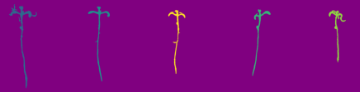